# Estimacion de Densidad

Cristobal Donoso Oliva<br>
Universidad de Concepcion, Chile<br>
cridonoso@inf.udec.cl<br>


_Viernes 20 de Noviembre del 2020_

La estimacion de densidad nos permite **relacionar observaciones con sus probabilidades**.

Si juntamos todas las probabilidades de una variable aleatoria, podemos **estimar** la **funcion de densidad de probabilidad (PDF)** 

Si tenemos el PDF podemos **aproximar** la probabilidad especifica de cualquier evento.

<img src='guille/images/density_estimation.png' />

Esto es util, por ejemplo para:
1. detectar outliers
2. estimar hiperparametros o parametros de un modelo
3. clasificacion, regresion o clustering

En general para estimar una densidad podemos utilizar modelos
- <u>Parametricos</u>: Se estiman los parametros de una funcion de densidad desde los datos (e.g., la media y la varianza de una distribucion normal)
- <u>No parametricos</u>: Se ajusta un modelo para una distribucion arbitraria

En el siguiente tutorial utilizaremos **datos astronomicos** correspondientes a **galaxias**

In [2]:
import pandas as pd
import numpy as np
import pylab as plt
import seaborn as sns; sns.set()

In [3]:
df = pd.read_csv('./data/SDSS_Gals.csv')
df.head()

,z,petroRad_r_kpc,absPetroMag_r
0,0.123945,16.159371,-21.933832
1,0.091500,10.336046,-21.383353
2,0.077116,15.770359,-21.973098
3,0.185233,18.595973,-21.888694
4,0.094941,8.508556,-21.342373


### 1.1 Histograma

La manera mas directa de estimar densidades de probabilidad es utilizando **Histogramas** (esto no corresponde a las clases descritas anteriormente como parametrico o no parametrico)

In [4]:
z = np.array(df['z'])
print(min(z), max(z))

0.00011789927 0.33818287


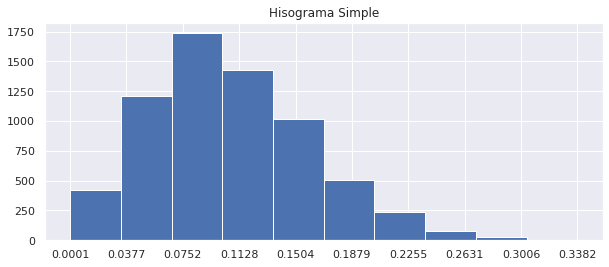

[ 421. 1207. 1737. 1430. 1014.  504.  240.   79.   26.    4.]


In [5]:
plt.figure(figsize=(10,4))
n, _, _ = plt.hist(z, bins = 10)
plt.title('Hisograma Simple')
plt.xticks(np.linspace(min(z),max(z), 10))
plt.show()
print(n) #Cantidad de valores por bin

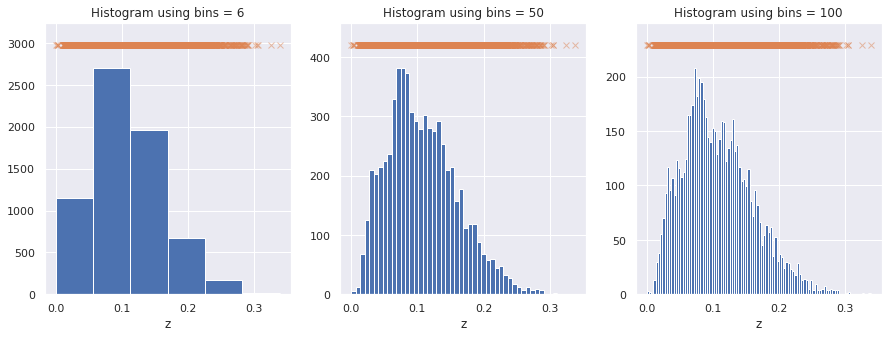

In [6]:
bins = [6, 50, 100]

fig, axes = plt.subplots(1,3, figsize=(15,5))

for index, b in enumerate(bins):
    n, _, _ = axes[index].hist(z, bins = b)
    
    axes[index].plot(z, np.ones(len(z))*n.max()*1.1, "x", alpha = 0.5)
    axes[index].set_title('Histogram using bins = '+str(b))
    axes[index].set_ylim([0, n.max()*1.2])
    axes[index].set_xlabel("z")
plt.show()

El PDF estimado es sensible a la cantidad de bins,

**Que podemos hacer para mejorar la estimacion?**
Cada punto es reemplazado por una caja con un alto y ancho predefinido.
Las cajas pueden solaparse.

La caja recibe el nombre de **KERNEL**

### 1.2 Kernel Density Estimation (KDE)

* Metodo no parametrico
* Cada punto esta asociado a un kernel
* La PDF corresponde a la suma sobre todos los kernels
* $\hat{f}_h(x) = \frac{1}{n}\sum K_h(x-x_i) = \frac{1}{nh}\sum K(\frac{x-x_i}{h})$
* $h$ es el ancho de banda que define el tamano del kernel. 

<img style='float: left;' src='./img/KDE1.png'>
<img style='float: right;' src='./img/KDE2.png'>

In [7]:
from sklearn.neighbors import KernelDensity

#### Kernels disponible en Scikitlearn
<img  height="150" width="450" style='float: right;' src='./img/kernels.png'>
<p style='float: left;'>
- Gaussian kernel $\rightarrow$ (kernel = 'gaussian')<br><br>
- Tophat kernel $\rightarrow$ (kernel = 'tophat')<br><br>
- Epanechnikov kernel $\rightarrow$ (kernel = 'epanechnikov')<br><br>
- Exponential kernel $\rightarrow$ (kernel = 'exponential')<br><br>
- Linear kernel $\rightarrow$ (kernel = 'linear')<br><br>
- Cosine kernel $\rightarrow$ (kernel = 'cosine')<br><br>
</p>

In [8]:
kde = KernelDensity(kernel='gaussian',bandwidth = 1e-2)
kde.fit(z[:, None])

KernelDensity(bandwidth=0.01)

Formalmente, un kernel es una foncion positiva $K(x;h)$, la cual es controlada por un parametro de ancho de banda $h$. 

La probabilidad estimada de un punto $x$ dentro de un conjunto de puntos $\{x_i\}_{i=1}^N$, esta dada por:

$\begin{equation}
p_K(x) = \frac{1}{Nh}\sum_{i=1}^NK(\frac{x-x_i}{h})
\end{equation}$

In [9]:
x = np.arange(0, 0.5, 0.01) # Definimos un rango de valores para calcular su probabilidad

`score_samples` retorna el logaritmo de la densidad de probabilidad. Esto para producir un estimador **definido positivamente**


In [10]:
prob = np.exp(kde.score_samples (x[:, None])) 

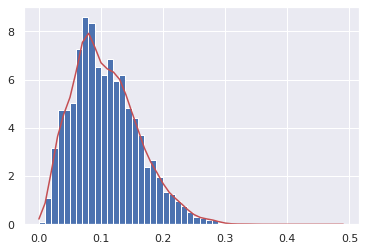

In [11]:
plt.clf()
plt.hist(z, bins = 34, density=True)
plt.plot(x, prob, "r")
plt.show()

## Seleccionando $h$ con Cross-Validation

Dado un conjunto de $N$ puntos, utilizamos $n-p$ muestras para entrenar el modelo y $p$ para testear. 

Este proceso de repite para todas las posibles combinaciones.

Luego el error correspondera al promedio de todas las ejecuciones para obtener una efectividad general

### Error cuadrático medio integrado (del ingles MISE)

Como sabemos, el valor de $h$ tiene un gran impacto sobre nuestra PDF estimada. Para poder selccionar el $h$ optimo, podemos minimizar el MISE:
$\begin{eqnarray}
MISE_h = \int(\hat{f}_h(x) - f(x))^2dx = \int\hat{f}_h^2dx - 2\int\hat{f}_hf(x)dx + \int f^2(x)dx
\end{eqnarray}$

donde,
* $\int\hat{f}_h^2dx$ se puede extraer desde los datos
* $\int f^2(x)dx$ no depende de $h$
* $\int\hat{f}_hf(x)dx = \mathbb{E}_x(\hat{f}_h(x))$, la esperanza se puede computar con respecto a una observacion independiente $x$ utilizando la estimacion.

Para estimar $\hat{f}_h(x)$ podemos utilizar la tecnica *leave one out*

$\begin{equation}
    \hat{\mathbb{E}}_x(\hat{f}_h(x)) =  \frac{1}{n}\sum_{i = 1}^n \hat{f}_{h, -i}(x_i)
\end{equation}$,

donde $\hat{f}_{h, -i}(x)$ es la estimacion de probabilidad dejando fuera el $i$-esimo punto.


Utilizando todo lo anterior podemos definir _cross-validation least-square score_

$CV(h) = \int\hat{f}_h^2(x)dx -\frac{2}{n}\sum_{i = 1}^n \hat{f}_{h, -i}(x_i)$,

y el valor optimo para $h$ correspondera a:

$\begin{equation}\hat{h}_CV = argmin_h CV(h)\end{equation}$.

### Validacion Cruzada con la Verosimilitud

Cuando hacemos estimacion de densidad, estamos esitmando el PDF de nuestros parametros. 

En ese sentido, podemos **estimar directamente** la **verosimilitud** de nuestro subconjunto de datos (i.e., leave-one-out)

La verosimilitud nos dice que **tan probable** es que los datos vengan de **nuestro modelo ajustado**

Si consideramos el costo de nuestro KDE como la verosimilitud sobre nuestro conjunto de datos, entonces solo debemos **maximizar la verosimilitud** de todos los puntos. 

Esto es equivalente a **maximizar el logaritmo** de nuestra PDF estimada

$CV_l(h) = \frac{1}{N}\sum_{i=1}^N\log{\hat{f}_{h,−i} (x_i)}$

y el valor optimo para $h$ seria:

$\hat{h}_{CV} = $argmax$_h CV(h)$.

In [12]:
from sklearn.model_selection import GridSearchCV

Utilizaremos `GridSearchCV` para estimar el valor de $h$. En otras palabras realizamos una **busqueda exahustiva** sobre el espacio de valores para nuestro parametro

In [13]:
# Muestreamos 100 puntos aleatorios 
z = np.array(df.sample(100)['z'])

# Espacio de valores
params = {'bandwidth': np.logspace(-3, 0, 20)}
grid = GridSearchCV(KernelDensity(), params)
grid = grid.fit(z[:, None])

In [14]:
like_mean = grid.cv_results_['mean_test_score']
like_std  = grid.cv_results_['std_test_score']
valores_h = [x['bandwidth'] for x in grid.cv_results_['params']]
mejor_h = grid.best_estimator_.bandwidth

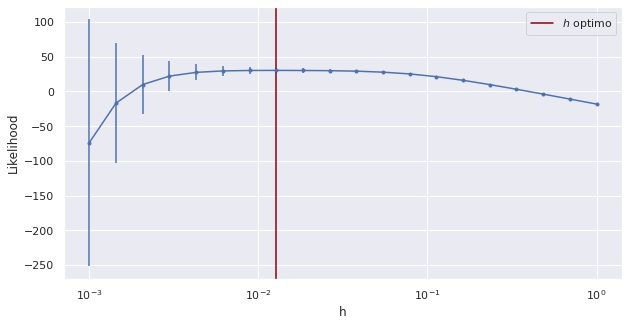

In [15]:
plt.figure(figsize=(10,5))
plt.errorbar(valores_h, like_mean, yerr=like_std, marker='.')
plt.xlabel ("h")
plt.ylabel ("Likelihood")
plt.axvline(grid.best_estimator_.bandwidth, color='darkred', label=r'$h$ optimo')
plt.xscale("log")
plt.legend()
plt.show()

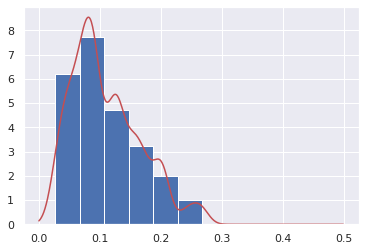

In [16]:
x = np.arange(0, 0.5, 0.001)
pdf = np.exp(grid.best_estimator_.score_samples(x[:, None]))

# Regla de"Scott's para calcular bins"
dh = 3.5 * z.std()/(len(z)**(1./3.))
b = int(np.round((z.max() - z.min())/dh))

plt.clf()
plt.hist(z, bins = b, density = True)
plt.plot(x, pdf, "r")
plt.show()

Ahora problemos con algo mas interesante: densidad de galaxias en termino de su radio y mangnitud

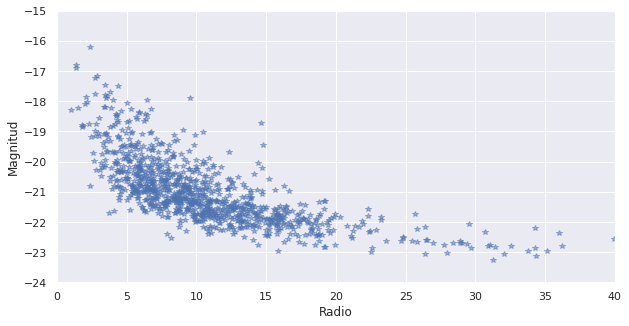

In [17]:
sample_1000 = df.sample(1000)
data = np.array([sample_1000['petroRad_r_kpc'], sample_1000['absPetroMag_r']]).transpose()

plt.figure(figsize=(10,5))
plt.plot(data[:, 0], data[:, 1], '*', alpha=0.5)
plt.xlim([0, 40])
plt.ylim([-24, -15])
plt.xlabel("Radio")
plt.ylabel("Magnitud")
plt.show()


In [18]:
# use grid search cross-validation to optimize the bandwidth
params = {'bandwidth': np.logspace(-3, 1, 20)}
grid = GridSearchCV(KernelDensity(), params)
grid.fit(data)

x = np.arange(.0, 40, 1)
y = np.arange(-24, -15, 0.2)

X, Y = np.meshgrid(x, y)
XY = np.array([X.flatten(), Y.flatten()]).transpose()

pdf = np.exp(grid.best_estimator_.score_samples (XY)).reshape(X.shape)


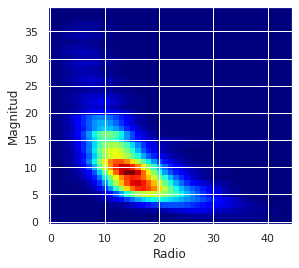

In [19]:
plt.figure()
plt.imshow(pdf.transpose(), interpolation='none', cmap=plt.cm.jet, origin='lower',clip_on=True)
plt.xlabel("Radio")
plt.ylabel("Magnitud")
plt.show()
    

Una vez que tenemos ajustado nuestro PDF podemos incluso **muestrar desde esa distribucion!**

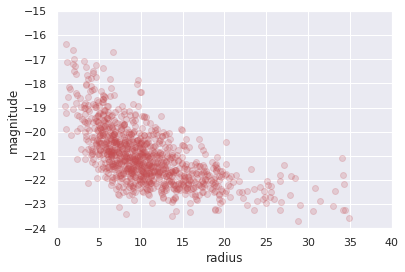

In [20]:
new_data = grid.best_estimator_.sample(1000, random_state=0)

plt.clf()
plt.plot(new_data[:, 0], new_data[:, 1], "ro", alpha = 0.2)
plt.xlabel("radius")
plt.ylabel("magnitude")
plt.xlim([0, 40])
plt.ylim([-24, -15])
plt.show()

## Gaussian Mixture Model

![image](https://d18l82el6cdm1i.cloudfront.net/uploads/ek1bu6ogj2-em_clustering_of_old_faithful_data.gif)

*(fuente imagen: https://brilliant.org/wiki/gaussian-mixture-model/)*

Diremos que $z_i\in \{1, \ldots, K\}$ representa un **estado latente discreto** desde el cual generamos los datos. 

Por ejemplo, $z_1 = (1, 0, 0,\ldots, 0), \cdots, z_K = (0, 0, 0,\ldots, 1)$ (variable categorica)

Ademas definimos un prior $p(z_i) = \boldsymbol{\pi}$ para cada uno de los estados, tal que $\sum_{i=1}^{K} \pi_i = 1$

Dado nuestro vector de estado $z_i$ la probabilidad de que las observaciones vengan de esta distribucion estara dado por:

$p(x_i | z_i = k) = p_k(x_i)$

Donde $p_k$ es la $k$-esima **distribucion base** para las observaciones (esta distribucion puede ser cualquiera). El modelo general es conocido como **mixture model** ya que mezcla las K distribuciones base 

$\begin{equation}
p(x_i|\Theta) = \sum_{k=1}^K\pi_kp_k(x_i|\Theta)
\end{equation}$

donde $\Theta$ corresponde a los parametros de nuestra distribucion base. 

Esta es una **combinacion convexa** ya que estamos tomando una suma ponderada que satisface $0 \geq \pi_k \geq 1$ y $\sum_k \pi_k = 1$

### Caso Gaussiano

El modelo de mezclas mas utilizado es Gausian mixture model (GMM).

En este caso nuestra **distribucion base** es una **Gaussiana Multivariada** con media $\mu_k$ t matriz de covarianza $\Sigma_k$

$p(x_i|\Theta) = \sum_{k=1}^K \pi_k \mathcal{N}(x_i|\mu_k, \Sigma_k)$

Dos estapas son necesarias a la hora de ajustar nuestro GMM:
- Ajustar los parametros de la funcion base (Expectation-Maximization) [[1]](https://perso.telecom-paristech.fr/bonald/documents/gmm.pdf)
- Definir el numero de gaussianas optimo (Model Selection): Criterio Akaike (AIC) o Bayesiano (BIC)

## Model Selection

Podemos utilizar cross-validation para encontrar el valor a nuestro hiperparametro. Sin embargo, existen metodos clasicos que son faciles de aplicar y mas efectivos para modelos simples. Dos de ellos son **Akaike Information Criterion (AIC)** and the **Bayesian Information Criterion (BIC)**.

En particular, tanto AIC como BIC penalizan segun la cantidad de parametros. 

Ademas ambos tienen la forma de:

$\begin{eqnarray}p(M|x) &\propto& p(x|M)p(M) \end{eqnarray}$

aplicando el logaritmo en ambas partes

$\begin{eqnarray} 
    \log(p(M|x)) &\propto& \log(p(x|M)) + \log(p(M))    
\end{eqnarray}$

donde $\log(p(x|M))$ es el likelihood (o verosimilitud) y $M$ representa los parametros del modelo


### Information Criteria

Considere $M$ parametros para un modelo y un conjunto de datos con $N$ muestras.

#### Akaike Information Criterion  

AIC $=2M-2\ln(\mathcal{L})$

donde $\mathcal{L}$ es el valor maximo para la verosimilitud del modelo.

#### Bayesian Information Criterion 

BIC $= -2\ln(\mathcal{L}) + M\ln(N)$   
   
A diferencia de AIC, BIC penaliza mas al modelo por su complejidad (cantidad de parametros)

In [21]:
from sklearn.mixture import GaussianMixture # sklearn 0.18

In [22]:
N_train = int(0.9*len(data))
data_train = data[:N_train]
data_test = data[N_train:]

In [23]:
Ns = np.arange(20) + 1 
models = [None for i in range(len(Ns))]
for i in range(len(Ns)):
    models[i] = GaussianMixture(Ns[i]).fit(data) # sklearn 0.18
    #print(models[i])

In [24]:
# compute the AIC and the BIC
AIC = [m.aic(data_train) for m in models]
BIC = [m.bic(data_train) for m in models]

# compute the cross-validated log-likelihood
logL = [m.score(data_test).mean() for m in models]

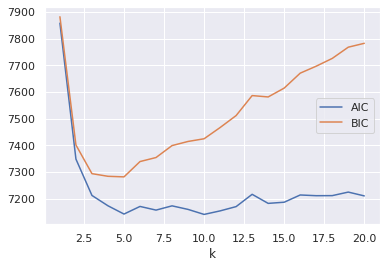

In [25]:
# plot metrics in terms of k
plt.clf()
plt.plot(Ns, AIC, label = "AIC")
plt.plot(Ns, BIC, label = "BIC")
plt.xlabel("k")
plt.legend (loc = "best")
plt.show()

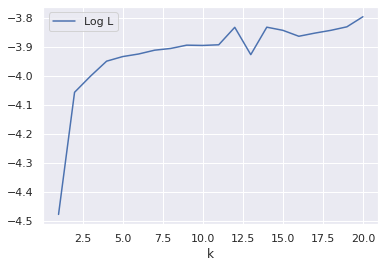

In [26]:
plt.clf()
plt.plot(Ns, logL, label = "Log L")
plt.xlabel("k")
plt.legend (loc = "best")
plt.show()

Mejor modelo segun BIC score con k = 5


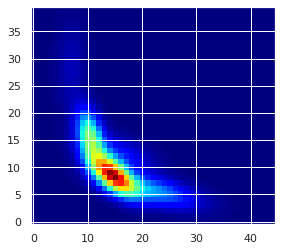

In [27]:
# plot the pdf of the best BIC model
print ("Mejor modelo segun BIC score con k = {0}".format( Ns[np.argmin(BIC)] ))

pdf = np.exp(models[np.argmin(BIC)].score_samples (XY)).reshape(X.shape)

plt.clf()
plt.imshow(pdf.transpose(), interpolation='none', cmap=plt.cm.jet, origin='lower',clip_on=True)
plt.show()